# Opschotdetectie
Deze notebook bevat een voorbeeld van opschotdetectie. Opschot zien we als ongewenste, houtachtige begroeiing op een steenbekleding van een waterkering. De methode om opschot te detecteren is in dit voorbeeld gebaseerd op zero-shot inference met de foundation models GroundingDino en SegmentAnything.

In [1]:
import os
import torch
import hydra
import torchvision
import numpy as np
import geopandas as gpd
from pathlib import Path
import tqdm
import rasterio.features
import shapely.geometry
import matplotlib.pyplot as plt
import matplotlib.axes
from typing import Union, List, Tuple, Iterable, Dict
import pycocotools.mask
from omegaconf import DictConfig
from PIL import Image
import torchvision.transforms as T
import logging
from logging.config import fileConfig

import groundingdino.util.inference
import groundingdino.util.utils

from hydra import initialize, compose

with initialize("config", version_base=None):
    cfg = compose("config.yaml")

## Voorbeeld foto met opschot
We passen de methode toe op een drone foto van een kering met steenbekleding. Op de steenbekleding is duidelijk opschot aanwezig:

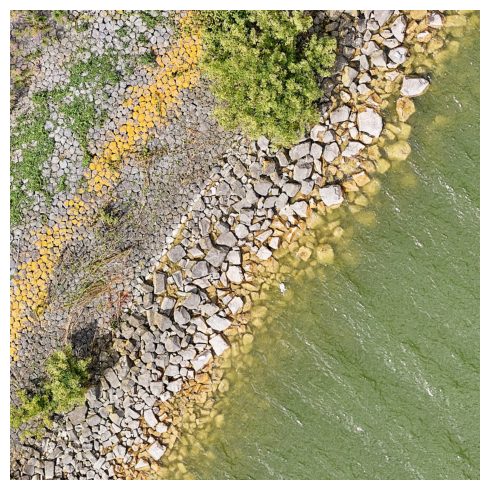

In [2]:
imgPath = 'images/test.jpeg'

# Load image
image_pil = Image.open(imgPath).convert("RGB")


# Define transformations
transform = T.Compose(
    [
        T.Resize(800),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Apply transformations
image = transform(image_pil)
image_np = np.array(image_pil)

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax.imshow(image_pil)
ax.axis("off")
fig.tight_layout();

## Foundation models
Om opschot te detecteren, moeten we de locatie van opschot bepalen en vervolgens uitknippen. De locatie bepalen we met behulp van GroundingDino, waarna we de precieze locatie uitknippen met SegmentAnything. Om dit te doen moeten we eerst de twee modellen inladen.

In [3]:
# Load Grounding Dino Model
dino_model = groundingdino.util.inference.load_model(
    cfg.GROUNDING_DINO_CONFIG_PATH,
    cfg.GROUNDING_DINO_CHECKPOINT_PATH,
    device="cuda:1",
)

# Load Segment Anything Model (SAM)
if cfg.USE_SAM_HQ:
    from segment_anything_hq import SamPredictor as SamPredictor_hq
    from segment_anything_hq import sam_model_registry as sam_model_registry_hq

    sam = sam_model_registry_hq[cfg.SAM_HQ_ENCODER_VERSION](
        checkpoint=cfg.SAM_HQ_CHECKPOINT_PATH
    ).to(device="cuda:1")
    sam_predictor = SamPredictor_hq(sam)
else:
    from segment_anything import SamPredictor, sam_model_registry

    sam = sam_model_registry[cfg.SAM_ENCODER_VERSION](
        checkpoint=cfg.SAM_CHECKPOINT_PATH
    ).to(device="cuda:1")
    sam_predictor = SamPredictor(sam)

/opt/tljh/user/envs/opschotdetectie2/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## Trefwoorden voor GroundingDino om opschot te detecteren
GroundingDino detecteert objecten op basis van een of meerdere trefwoorden ('tags'). In dit voorbeeld geven we de trefwoorden 'bush', 'shrub', 'tree' en 'plant' mee aan GroundingDino om opschot te detecteren. GroundingDino produceert op basis van deze trefwoorden bounding boxes in de figuur waar deze trefwoorden worden aangetroffen. Op basis van Non-maximum-Supression worden overlappende bounding boxes tot 1 box samengevoegd.

/opt/tljh/user/envs/opschotdetectie2/lib/python3.11/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/tljh/user/envs/opschotdetectie2/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/tljh/user/envs/opschotdetectie2/lib/python3.11/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


NMS: before 3 boxes, after 2 boxes


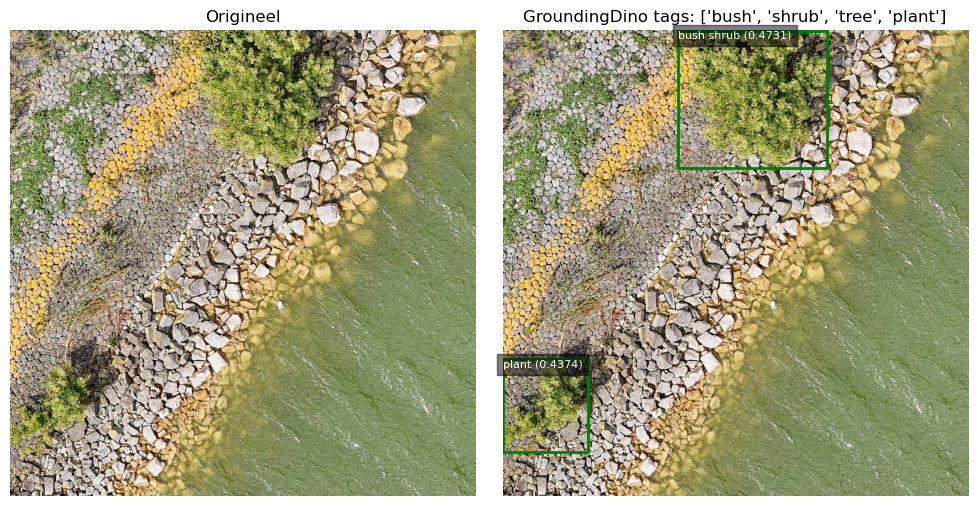

In [4]:
tag_list = ["bush", "shrub", "tree", "plant"]
tags = ". ".join(tag_list)

def get_grounding_output(
    model: torch.nn.Module,
    image: torch.Tensor,
    caption: str,
    box_threshold: float,
    text_threshold: float,
    device: str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor, List[str]]:
    """
    Process an image and caption through a model to generate grounded outputs,
    including filtered bounding boxes and corresponding text phrases.

    Parameters:
    - model (torch.nn.Module): The model to process the input data.
    - image (torch.Tensor): The image tensor.
    - caption (str): The caption string related to the image.
    - box_threshold (float): The threshold value to filter the bounding boxes based on confidence scores.
    - text_threshold (float): The threshold value to filter the text based on logits.
    - device (str, optional): The device type, 'cpu' or 'cuda', where the computation will take place. Defaults to 'cpu'.

    Returns:
    - tuple:
        - filtered_boxes (torch.Tensor): The filtered bounding boxes.
        - scores (torch.Tensor): The confidence scores of the phrases.
        - pred_phrases (list of str): The predicted phrases associated with the bounding boxes.
    """
    # Prepare caption
    caption = caption.lower().strip()
    if not caption.endswith("."):
        caption += "."

    # Move model and image to the specified device
    model = model.to(device)
    image = image.to(device)

    # Generate predictions
    try:
        with torch.no_grad():
            outputs = model(
                image.unsqueeze(0), captions=[caption]
            )  # Ensure image is 4D
        logits = outputs["pred_logits"].sigmoid()[0]  # (num_queries, num_classes)
        boxes = outputs["pred_boxes"][0]  # (num_queries, 4)

        # Filter outputs based on thresholds
        max_logits = logits.max(dim=1)[0]
        filt_mask = max_logits > box_threshold
        logits_filt = logits[filt_mask]
        boxes_filt = boxes[filt_mask]

        # Prepare phrases and scores
        tokenizer = model.tokenizer
        tokenized = tokenizer(caption)
        pred_phrases, scores = [], []
        for logit, box in zip(logits_filt, boxes_filt):
            pred_phrase = groundingdino.util.utils.get_phrases_from_posmap(
                logit > text_threshold, tokenized, tokenizer
            )
            pred_phrases.append(f"{pred_phrase} ({logit.max().item():.4f})")
            scores.append(logit.max().item())

        return boxes_filt, torch.tensor(scores), pred_phrases
    except Exception as e:
        raise Exception(f"An error occurred during model prediction: {e}")

# Find bounding boxes with grounding dino
boxes_filt, scores, pred_phrases = get_grounding_output(
    dino_model,
    image,
    tags,
    0.35,
    0.25,
    device="cuda:1",
)
boxes_filt =boxes_filt.cpu()

 # Resize boxes
size = image_pil.size
H, W = size[1], size[0]
for i in range(boxes_filt.size(0)):
    boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
    boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
    boxes_filt[i][2:] += boxes_filt[i][:2]

# use NMS to handle overlapped boxes
nms_idx = (
    torchvision.ops.nms(boxes_filt, scores, 0.5).numpy().tolist()
)
if cfg.DO_IOU_MERGE:
    boxes_filt_clean = boxes_filt[nms_idx]
    pred_phrases_clean = [pred_phrases[idx] for idx in nms_idx]
    print(f"NMS: before {boxes_filt.shape[0]} boxes, after {boxes_filt_clean.shape[0]} boxes")
else:
    boxes_filt_clean = boxes_filt
    pred_phrases_clean = pred_phrases

def show_box(box: Iterable[float], ax: matplotlib.axes.Axes, label: str) -> None:
    x0, y0 = box[0], box[1]
    w, h = box[2] - x0, box[3] - y0
    rect = plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor="none", lw=2)
    ax.add_patch(rect)
    ax.text(
        x0,
        y0,
        label,
        verticalalignment="top",
        color="white",
        fontsize=8,
        bbox={"facecolor": "black", "alpha": 0.5},
    )
    return None

fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=100, squeeze=False)

ax = axs[0, 0]
ax.imshow(image_np)
ax.set_title("Origineel", wrap=True)
ax.axis("off");

ax = axs[0, 1]
ax.imshow(image_np)
for box, label in zip(boxes_filt_clean, pred_phrases_clean):
    show_box(box.numpy(), ax, label)
ax.set_title(f"GroundingDino tags: {tag_list}", wrap=True)
ax.axis("off")
fig.tight_layout();

## Uitknippen van opschot met SegmentAnything
Op basis van de zojuist gedetecteerde objecten, kunnen met SegmentAnything de contouren gedetecteerd worden.

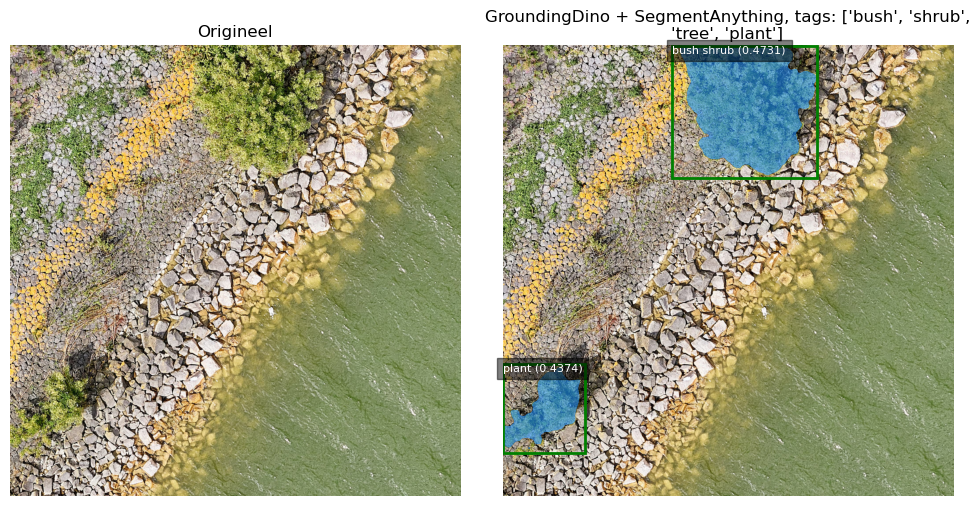

In [5]:
def show_mask(
    mask: np.ndarray, ax: matplotlib.axes.Axes, random_color: bool = False
) -> None:
    if random_color:
        color = np.random.rand(3)  # Generates three random floats between 0 and 1
        color = np.append(color, 0.6)  # Add alpha for transparency
    else:
        color = np.array(
            [30 / 255, 144 / 255, 255 / 255, 0.6]
        )  # Deep sky blue with transparency

    h, w = mask.shape
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return None

# Segment objects with SAM
sam_predictor.set_image(image_np)
transformed_boxes = sam_predictor.transform.apply_boxes_torch(
    boxes_filt_clean, image_np.shape[:2]
).to("cuda:1")
masks, _, _ = sam_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes.to("cuda:1"),
    multimask_output=False,
)

for cat_title, mask in zip(pred_phrases_clean, masks):
    mask = mask.cpu().numpy()

# Setup figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=100, squeeze=False)

ax = axs[0, 0]
ax.imshow(image_np)
ax.set_title("Origineel", wrap=True)
ax.axis("off");

ax = axs[0, 1]
ax.imshow(image_np)
for mask in masks:
    show_mask(mask[0,...].cpu().numpy(), ax, random_color=False)
for box, label in zip(boxes_filt_clean, pred_phrases_clean):
    show_box(box.numpy(), ax, label)
ax.set_title(f"GroundingDino + SegmentAnything, tags: {tag_list}", wrap=True)
ax.axis("off")
fig.tight_layout();